In [2]:
%reset -f

# 🎇 ML Project - SoSe25
**Project:** Airbnb price prediction in Berlin, Germany<br>
**Model:** Catboost GradientBoosted Tree

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [4]:
pd.set_option('display.max_columns', None)
import numpy as np
np.version.version

'2.0.2'

In [5]:
# Load from pickle file
with open('cleaned_listing_data.pkl', 'rb') as f:
    df = pickle.load(f).reset_index(drop=True)

print(df.shape)
df

(8890, 73)


,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance_alex,distance_isle_of_museums,distance_brandenburg_gate,distance_zoo,distance_charlottenburg_castle,distance_berlin_wall,closest_station,distance_closest_station,number_of_lines,is_west_berlin
0,3176,3718,Britta,2008-10-19,Outside Germany,within a day,67.0,40.0,False,Prenzlauer Berg,1.0,1.0,"['email', 'phone']",True,True,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.534710,13.418100,Entire rental unit,Entire home/apt,2,1.0,1.0,2.0,"[""Bathtub"", ""Dishes and silverware"", ""Bed line...",105.0,63,730,1.0,63.0,730.0,730.0,62.7,730.0,False,0,0,11,286,149,1,1,212,0,126,13230.0,2009-06-20,2025-03-02,4.63,4.67,4.52,4.65,4.70,4.92,4.61,False,1,1,0,0,0.78,1.539717,2.263045,3.376051,6.125432,8.434369,3.806687,Senefelderplatz,0.452641,1,False
1,9991,33852,Philipp,2009-08-25,Berlin,a few days or more,0.0,0.0,False,Prenzlauer Berg,1.0,1.0,"['email', 'phone']",True,True,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.532690,13.418050,Entire rental unit,Entire home/apt,7,2.5,4.0,4.0,"[""Bathtub"", ""Dryer"", ""Dishes and silverware"", ...",135.0,6,14,6.0,6.0,14.0,14.0,6.0,14.0,False,0,0,0,109,7,0,0,35,0,0,0.0,2015-08-09,2020-01-04,5.00,5.00,5.00,5.00,5.00,4.86,4.86,False,1,1,0,0,0.06,1.325206,2.075153,3.246219,6.016864,8.395741,3.607563,Senefelderplatz,0.377216,1,False
2,14325,55531,Chris + Oliver,2009-11-18,Berlin,within a few hours,100.0,38.0,True,Prenzlauer Berg,4.0,5.0,"['email', 'phone', 'work_email']",True,True,None,Prenzlauer Berg Nordwest,Pankow,52.548130,13.403660,Entire rental unit,Entire home/apt,1,1.0,0.0,1.0,"[""Heating"", ""Host greets you"", ""Smoke alarm"", ...",75.0,150,1125,150.0,150.0,1125.0,1125.0,150.0,1125.0,False,0,0,0,165,26,0,0,91,0,0,0.0,2010-06-29,2023-11-30,4.68,5.00,4.85,4.70,4.85,4.60,4.45,False,4,4,0,0,0.15,3.013079,3.408976,3.893683,6.249913,7.894639,5.582943,Schönhauser Allee,0.777859,2,False
3,16644,64696,Rene,2009-12-20,Outside Germany,None,NaN,0.0,False,Kreuzberg,4.0,4.0,"['email', 'phone']",True,True,"Berlin, Germany",nördliche Luisenstadt,Friedrichshain-Kreuzberg,52.503120,13.435080,Entire condo,Entire home/apt,4,1.0,1.0,1.0,"[""Heating"", ""Room-darkening shades"", ""Children...",77.0,93,365,93.0,93.0,365.0,365.0,93.0,365.0,False,0,0,0,196,48,0,0,122,0,0,0.0,2010-06-04,2017-12-14,4.72,4.86,4.86,4.93,4.86,4.67,4.71,False,2,2,0,0,0.27,2.596106,2.865028,4.175790,6.536968,9.691065,0.523791,Schlesisches Tor,0.514633,2,True
4,17904,68997,Matthias,2010-01-08,Outside Germany,within an hour,100.0,95.0,False,Copacabana,2.0,5.0,"['email', 'phone']",True,True,"Berlin, Germany",Reuterstraße,Neukölln,52.494190,13.421660,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,"[""Dishes and silverware"", ""Luggage dropoff all...",40.0,92,365,92.0,92.0,365.0,365.0,92.0,365.0,False,0,0,0,29,299,0,0,29,0,0,0.0,2010-02-18,2022-12-

In [6]:
df['log_price'] = np.log(df.price)
df.price.mean(), df.log_price.mean()

(np.float64(119.9933633295838), np.float64(4.573513349577792))

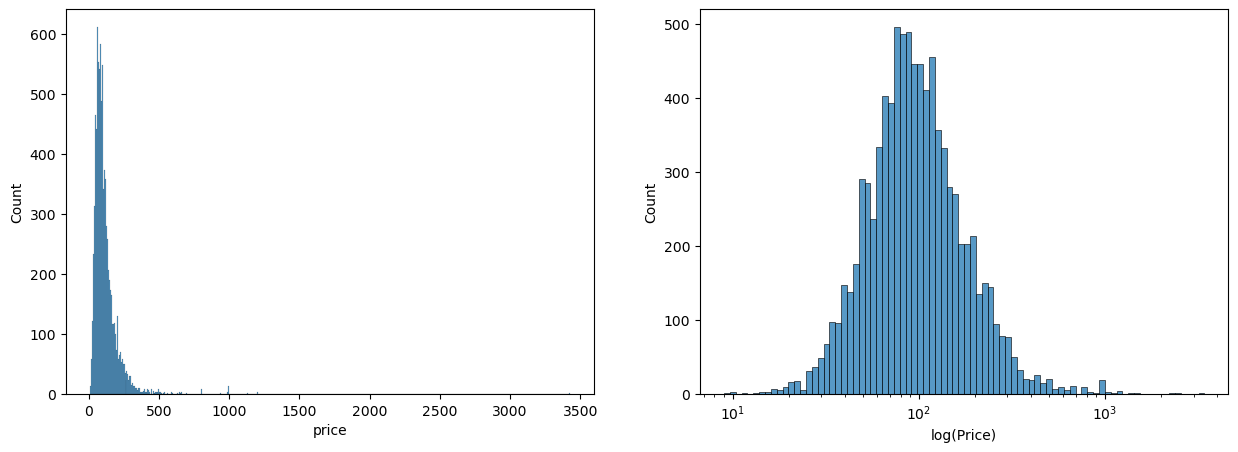

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.histplot(df.price[df.price<5000])

plt.subplot(1, 2, 2)
sns.histplot(df.price[df.price<5000], log_scale=True)
plt.xlabel('log(Price)')
plt.show()

In [8]:
[i for i in df.columns if 'estimat' in i]

['estimated_occupancy_l365d', 'estimated_revenue_l365d']

In [9]:
df.groupby(['host_verifications'])['price'].agg(['count','mean']).round(2)

,count,mean
host_verifications,,
"['email', 'phone', 'work_email']",1151,118.75
"['email', 'phone']",7022,120.53
['email'],6,85.33
"['phone', 'work_email']",48,102.00
['phone'],640,117.15
[],4,147.25


### Amenties column: Expand to make bools of individual amenities per row in our df
The code below is commented out because this unpacking of all amenities creating ~1500 one-hot encoded features did not improve results at all. 

In [10]:
# %%time
# # Convert amenities to lists (using your eval approach)
# amenities = pd.Series(map(eval, df.amenities))
# print(amenities.shape)

# # Normalize text: lowercase + replace spaces with underscores
# normalized_amenities = amenities.apply(lambda lst: [i.lower().replace(' ', '_') for i in lst])
# print(normalized_amenities.shape)

# # One-hot encode
# amenities_expanded = pd.get_dummies(normalized_amenities.explode()).groupby(level=0).max()
# amenities_expanded = amenities_expanded.add_prefix('amenity_')
# print(amenities_expanded.shape)

# # Merge back
# print(df.shape)
# amenities_expanded = amenities_expanded.reindex(df.index, fill_value=0) 
# df = pd.concat([df.drop(['amenities'], axis=1), amenities_expanded], axis=1)
# print(df.shape)

In [11]:
df.dtypes['host_is_superhost']

dtype('bool')

In [12]:
remove_columns = ['id','host_name', 'amenities','host_verifications','price']

df = df.drop(remove_columns, axis=1)
df.head(2)

,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance_alex,distance_isle_of_museums,distance_brandenburg_gate,distance_zoo,distance_charlottenburg_castle,distance_berlin_wall,closest_station,distance_closest_station,number_of_lines,is_west_berlin,log_price
0,3718,2008-10-19,Outside Germany,within a day,67.0,40.0,False,Prenzlauer Berg,1.0,1.0,True,True,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,2,1.0,1.0,2.0,63,730,1.0,63.0,730.0,730.0,62.7,730.0,False,0,0,11,286,149,1,1,212,0,126,13230.0,2009-06-20,2025-03-02,4.63,4.67,4.52,4.65,4.7,4.92,4.61,False,1,1,0,0,0.78,1.539717,2.263045,3.376051,6.125432,8.434369,3.806687,Senefelderplatz,0.452641,1,False,4.653960
1,33852,2009-08-25,Berlin,a few days or more,0.0,0.0,False,Prenzlauer Berg,1.0,1.0,True,True,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,2.5,4.0,4.0,6,14,6.0,6.0,14.0,14.0,6.0,14.0,False,0,0,0,109,7,0,0,35,0,0,0.0,2015-08-09,2020-01-04,5.00,5.00,5.00,5.00,5.0,4.86,4.86,False,1,1,0,0,0.06,1.325206,2.075153,3.246219,6.016864,8.395741,3.607563,Senefelderplatz,0.377216,1,False,4.905275


In [13]:
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
categorical_features

['host_id',
 'host_location',
 'host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'has_availability',
 'instant_bookable',
 'closest_station',
 'is_west_berlin']

## Evaluate Regression model function
It prints R2 and RMSE for any given train-test sets

In [14]:
from sklearn.metrics import root_mean_squared_error, r2_score
from tabulate import tabulate

def evaluate_regression_model(model, X_train, y_train, X_test, y_test):
    # Get predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    metrics = [
        ["RMSE", 
         root_mean_squared_error(y_train, y_pred_train),
         root_mean_squared_error(y_test, y_pred_test)],
        ["R²", 
         r2_score(y_train, y_pred_train),
         r2_score(y_test, y_pred_test)]
    ]
    
    # Print table
    print("\n->Evaluation Metrics:")
    print(tabulate(metrics, 
                   headers=["Metric", "Train", "Test"], 
                   floatfmt=".3f",
                   tablefmt="grid"))

# 1️⃣ Baseline model
Making catboost work with available data

0:	learn: 0.0624122	test: 0.0626708	best: 0.0626708 (0)	total: 2.07ms	remaining: 1.03s
50:	learn: 0.5755176	test: 0.6058968	best: 0.6058968 (50)	total: 67.8ms	remaining: 597ms
100:	learn: 0.6564548	test: 0.6853961	best: 0.6853961 (100)	total: 137ms	remaining: 539ms
150:	learn: 0.6972716	test: 0.7274292	best: 0.7274292 (150)	total: 202ms	remaining: 467ms
200:	learn: 0.7235651	test: 0.7531670	best: 0.7531670 (200)	total: 272ms	remaining: 404ms
250:	learn: 0.7448903	test: 0.7695908	best: 0.7695908 (250)	total: 337ms	remaining: 334ms
300:	learn: 0.7566875	test: 0.7787739	best: 0.7787739 (300)	total: 402ms	remaining: 266ms
350:	learn: 0.7667858	test: 0.7857129	best: 0.7857307 (349)	total: 469ms	remaining: 199ms
400:	learn: 0.7765169	test: 0.7928333	best: 0.7928333 (400)	total: 533ms	remaining: 131ms
450:	learn: 0.7863461	test: 0.8007732	best: 0.8007732 (450)	total: 602ms	remaining: 65.4ms
499:	learn: 0.7938332	test: 0.8053759	best: 0.8055917 (497)	total: 670ms	remaining: 0us

bestTest = 0.8

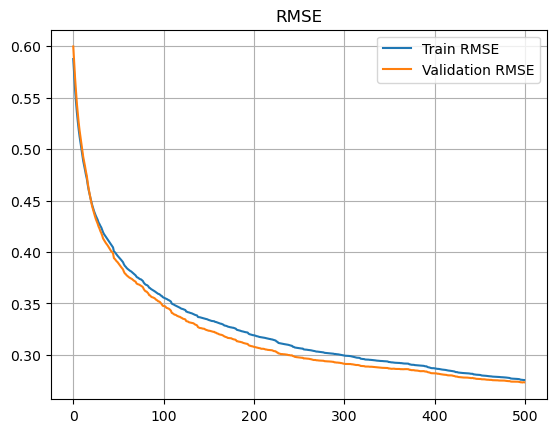

CPU times: user 4.21 s, sys: 560 ms, total: 4.77 s
Wall time: 863 ms


(None, <matplotlib.legend.Legend at 0x14e13c8c0>, Text(0.5, 1.0, 'RMSE'), None)

In [17]:
%%time
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Step 1: Prepare the features (X) and target (y)
X = df.drop(columns=['log_price'])
y = df[['log_price']]

# Categorical features
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Make sure these features are of object type
X = X.astype({i:str for i in categorical_features})

# Date Features:
date_cols = ['host_since', 'first_review', 'last_review']  # Replace with your date columns
for col in date_cols:
    X[col] = pd.to_datetime(X[col]).astype('int64')  # Convert to Unix timestamp

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize CatBoostRegressor with parameters and specify categorical features
model = CatBoostRegressor(
    iterations=500,            # Number of boosting iterations
    learning_rate=0.1,         # Step size for each iteration, balances speed and accuracy
    depth=2,                   # Depth of each tree, higher depth may improve accuracy but increases overfitting risk
    loss_function='RMSE',      # Loss function to optimize, RMSE is suitable for regression tasks
    eval_metric='R2',        # Metric for evaluating model performance on validation set. The verbose output will show this metric for train/test sets
    random_seed=42,            # Seed for reproducibility
    verbose=50,                # Frequency of training log output
)

# Step 4: Train the model on the training data
# model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features, early_stopping_rounds=50)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=categorical_features,
    early_stopping_rounds=50,
    verbose=50,
    # plot=True  # Optional: Shows live R²/RMSE plot
)

# Step 5: Evaluate the model
evaluate_regression_model(model, X_train, y_train, X_test, y_test)

# Extract training/validation loss history
train_loss = model.evals_result_['learn']['RMSE']  # Training loss
val_loss = model.evals_result_['validation']['RMSE']  # Validation loss

# Plot the loss curves
plt.plot(train_loss, label='Train RMSE')
plt.plot(val_loss, label='Validation RMSE')
plt.grid(True), plt.legend(), plt.title("RMSE"), plt.show()

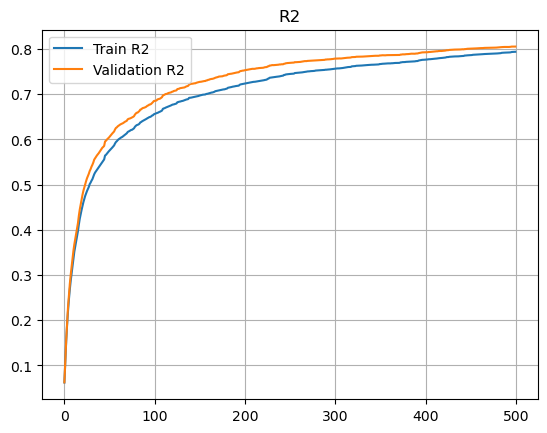

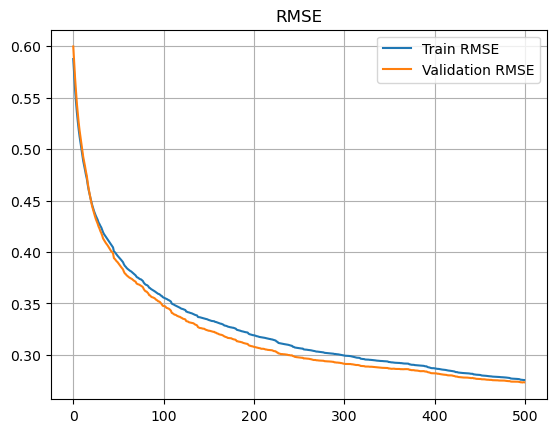

(None, <matplotlib.legend.Legend at 0x14b9d2c60>, Text(0.5, 1.0, 'RMSE'), None)

In [18]:
# Extract training/validation loss history
train_r2 = model.evals_result_['learn']['R2']
val_r2 = model.evals_result_['validation']['R2']  
train_loss = model.evals_result_['learn']['RMSE']  # Training loss
val_loss = model.evals_result_['validation']['RMSE']  # Validation loss

# Plot the R2 curves
plt.plot(train_r2, label='Train R2')
plt.plot(val_r2, label='Validation R2')
plt.grid(True), plt.legend(), plt.title("R2"), plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Train RMSE')
plt.plot(val_loss, label='Validation RMSE')
plt.grid(True), plt.legend(), plt.title("RMSE"), plt.show()

In [19]:
import pandas as pd

# Find columns with NaT values
nat_columns = df.columns[df.isna().any() & (df.apply(lambda x: pd.api.types.is_datetime64_any_dtype(x)))]

# Calculate percentage of NaT values in each column
nat_percentage = {col: (df[col].isna().mean() * 100) for col in nat_columns}

print("Columns with NaT values:", nat_columns.tolist())
print("Percentage of NaT values:", nat_percentage)

Columns with NaT values: ['host_since', 'first_review', 'last_review']
Percentage of NaT values: {'host_since': np.float64(0.21372328458942633), 'first_review': np.float64(22.992125984251967), 'last_review': np.float64(22.992125984251967)}


## 📊 Feature Importance Plots
To find top features used across our trees

,feature,importance
42,estimated_revenue_l365d,19.610937
17,property_type,14.539605
21,bedrooms,11.852961
41,estimated_occupancy_l365d,9.676775
0,host_id,8.234429


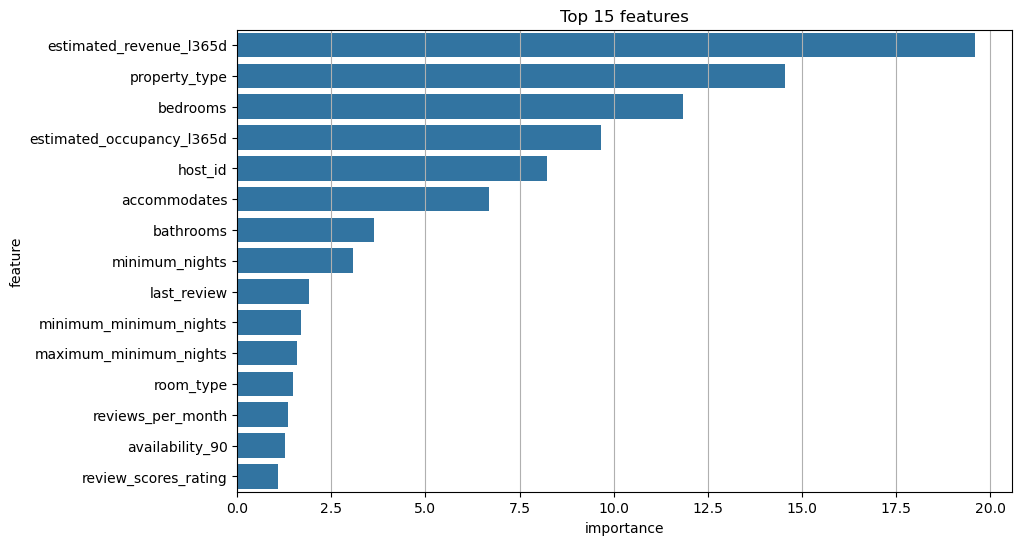

In [20]:
# Step 6: Feature importance plot
feature_importances = pd.DataFrame({
                        'feature' : X.columns,
                        'importance' : model.get_feature_importance()
                                 })

feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.grid()
sns.barplot(data=feature_importances[0:15], y='feature', x='importance', orient='h').set_title("Top 15 features")

feature_importances[0:5]

In [21]:
model.get_params()

{'iterations': 500,
 'learning_rate': 0.1,
 'depth': 2,
 'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': 50,
 'eval_metric': 'R2'}

# 🐦‍🔥 GridSearch for hyperparameter tuning.
I am going to find best depth and learning rate because I think keeping n_iterators=1000 is fine since GB is early_stopping anyways

In [22]:
%%time
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# Step 1: Prepare features and target (same as before)
X = df.drop(columns=['log_price'])
y = df[['log_price']]

# Categorical features and date processing (same as before)
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
X = X.astype({i:str for i in categorical_features})
date_cols = ['host_since', 'first_review', 'last_review']
for col in date_cols:
    X[col] = pd.to_datetime(X[col]).astype('int64')

# Step 2: Split into train and test ONCE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Proper grid search with train/val split from ONLY training data
param_grid = {
    'iterations': [1000, 2000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [2, 4, 6, 7]
}

# Create validation set from ONLY training data and keep test_data untouched
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60/20/20 split on everall data.

grid_search = GridSearchCV(
    estimator=CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='R2',
        random_seed=42,
        verbose=0,
    ),
    param_grid=param_grid,
    cv=[(list(range(len(X_train_train))), list(range(len(X_train_train),len(X_train)))) ],
    scoring='r2',
    n_jobs=4,
    verbose=1,
)

# Train ONLY on training data (X_train)
grid_search.fit(
    X_train, y_train,
    eval_set=(X_val, y_val), # Validation from train split
    cat_features=categorical_features,
    early_stopping_rounds=50,
)

# Get best model and evaluation on validation set and held and my held-out test set
best_model = grid_search.best_estimator_
print(f"->Best GridSearch params: {grid_search.best_params_}")
print(f"->Best params: {best_model.get_params()}")
print(f"->Best Score: {grid_search.best_score_:.4f}")

print("\n->Validation Set Performance:")
evaluate_regression_model(best_model, X_train_train, y_train_train, X_val, y_val)
print("\n->Test Set Performance:")
evaluate_regression_model(best_model, X_train, y_train, X_test, y_test)

Fitting 1 folds for each of 24 candidates, totalling 24 fits
->Best GridSearch params: {'depth': 6, 'iterations': 2000, 'learning_rate': 0.1}
->Best params: {'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 0, 'eval_metric': 'R2', 'depth': 6, 'iterations': 2000, 'learning_rate': 0.1}
->Best Score: 0.8508

->Validation Set Performance:

->Evaluation Metrics:
+----------+---------+--------+
| Metric   |   Train |   Test |
+==========+=========+========+
| RMSE     |   0.102 |  0.112 |
+----------+---------+--------+
| R²       |   0.972 |  0.965 |
+----------+---------+--------+

->Test Set Performance:

->Evaluation Metrics:
+----------+---------+--------+
| Metric   |   Train |   Test |
+==========+=========+========+
| RMSE     |   0.105 |  0.236 |
+----------+---------+--------+
| R²       |   0.970 |  0.855 |
+----------+---------+--------+
CPU times: user 1min 9s, sys: 7.29 s, total: 1min 16s
Wall time: 1min 44s


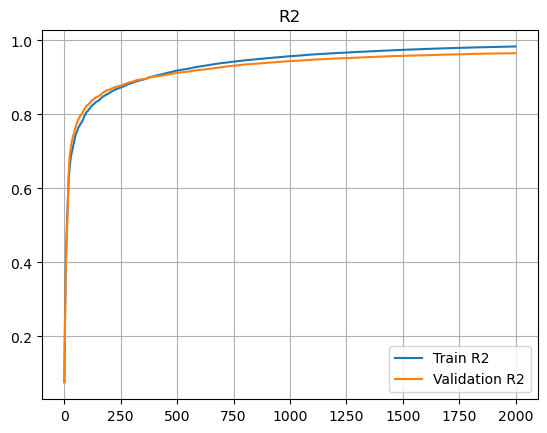

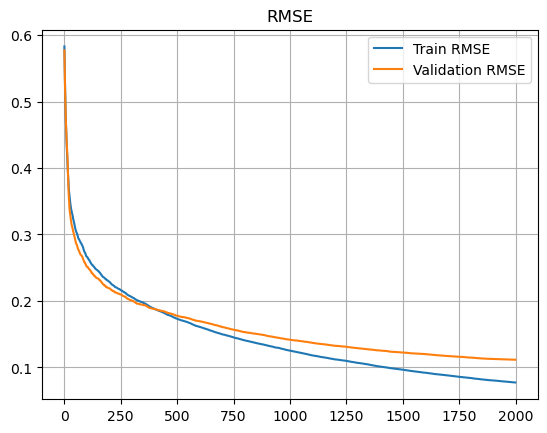

(None, <matplotlib.legend.Legend at 0x14e47dfa0>, Text(0.5, 1.0, 'RMSE'), None)

In [25]:
# Extract training/validation loss history
train_r2 = best_model.evals_result_['learn']['R2']
val_r2 = best_model.evals_result_['validation']['R2']  
train_loss = best_model.evals_result_['learn']['RMSE']  # Training loss
val_loss = best_model.evals_result_['validation']['RMSE']  # Validation loss

# Plot the R2 curves
plt.plot(train_r2, label='Train R2')
plt.plot(val_r2, label='Validation R2')
plt.grid(True), plt.legend(), plt.title("R2"), plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Train RMSE')
plt.plot(val_loss, label='Validation RMSE')
plt.grid(True), plt.legend(), plt.title("RMSE"), plt.show()

In [26]:
grid_search_results_sklearn = pd.DataFrame(grid_search.cv_results_)
# grid_search_results[['rank_test_score','params', 'mean_test_score', 'mean_fit_time']]
grid_search_results_sklearn.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_learning_rate,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
16,26.097102,0.0,0.028000,0.0,6,2000,0.1,"{'depth': 6, 'iterations': 2000, 'learning_rat...",0.850800,0.850800,0.0,1
13,12.578170,0.0,0.016913,0.0,6,1000,0.1,"{'depth': 6, 'iterations': 1000, 'learning_rat...",0.848837,0.848837,0.0,2
17,25.687942,0.0,0.022475,0.0,6,2000,0.2,"{'depth': 6, 'iterations': 2000, 'learning_rat...",0.848205,0.848205,0.0,3
14,12.903145,0.0,0.016687,0.0,6,1000,0.2,"{'depth': 6, 'iterations': 1000, 'learning_rat...",0.847525,0.847525,0.0,4
22,29.110170,0.0,0.014316,0.0,7,2000,0.1,"{'depth': 7, 'iterations': 2000, 'learning_rat...",0.847339,0.847339,0.0,5


,feature,importance
42,estimated_revenue_l365d,17.371417
17,property_type,10.347661
41,estimated_occupancy_l365d,9.049794
21,bedrooms,7.234720
0,host_id,4.362191


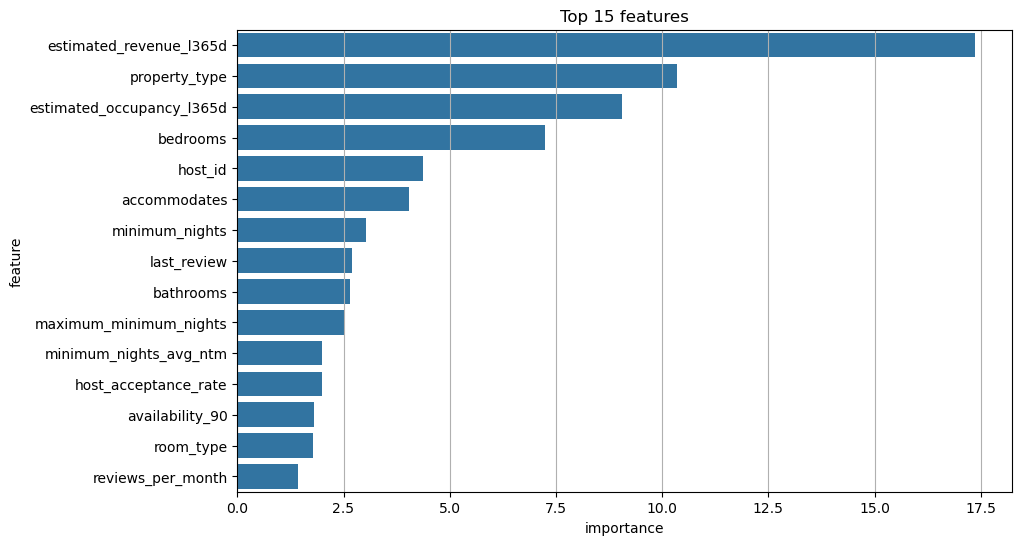

In [27]:
# Step 6: Feature importance plot
feature_importances = pd.DataFrame({
                        'feature' : X.columns,
                        'importance' : best_model.get_feature_importance()
                                 })

feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.grid()
sns.barplot(data=feature_importances[0:15], y='feature', x='importance', orient='h').set_title("Top 15 features")

feature_importances[0:5]

# 🦄 Final model 
w/ best parameters

In [35]:
best_model_params = best_model.get_params()
best_model_params['verbose'] = 200
best_model_params

{'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': 200,
 'eval_metric': 'R2',
 'depth': 6,
 'iterations': 2000,
 'learning_rate': 0.1}

0:	learn: 0.0772997	test: 0.0748600	best: 0.0748600 (0)	total: 16.7ms	remaining: 33.5s
50:	learn: 0.7447672	test: 0.7615351	best: 0.7615351 (50)	total: 273ms	remaining: 10.4s
100:	learn: 0.8072223	test: 0.8094519	best: 0.8094519 (100)	total: 505ms	remaining: 9.5s
150:	learn: 0.8372468	test: 0.8264185	best: 0.8264185 (150)	total: 772ms	remaining: 9.45s
200:	learn: 0.8578919	test: 0.8346496	best: 0.8346496 (200)	total: 1.02s	remaining: 9.1s
250:	learn: 0.8728829	test: 0.8402484	best: 0.8402484 (250)	total: 1.28s	remaining: 8.9s
300:	learn: 0.8853450	test: 0.8440081	best: 0.8440760 (297)	total: 1.52s	remaining: 8.6s
350:	learn: 0.8945237	test: 0.8454991	best: 0.8454991 (350)	total: 1.76s	remaining: 8.29s
400:	learn: 0.9040068	test: 0.8464613	best: 0.8466236 (374)	total: 2.02s	remaining: 8.04s
450:	learn: 0.9114982	test: 0.8476553	best: 0.8476553 (450)	total: 2.26s	remaining: 7.76s
500:	learn: 0.9186142	test: 0.8497973	best: 0.8498192 (498)	total: 2.5s	remaining: 7.49s
550:	learn: 0.923777

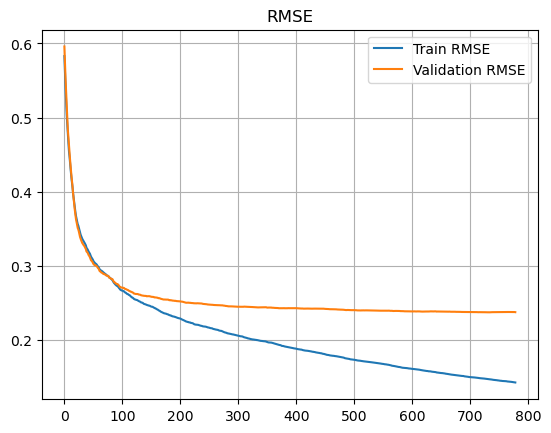

CPU times: user 25.8 s, sys: 2.54 s, total: 28.3 s
Wall time: 4.06 s


(None, <matplotlib.legend.Legend at 0x14e246ae0>, Text(0.5, 1.0, 'RMSE'), None)

In [36]:
%%time
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Step 1: Prepare the features (X) and target (y)
X = df.drop(columns=['log_price'])
y = df[['log_price']]

# Categorical features
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Make sure these features are of object type
X = X.astype({i:str for i in categorical_features})

# Date Features:
date_cols = ['host_since', 'first_review', 'last_review']  # Replace with your date columns
for col in date_cols:
    X[col] = pd.to_datetime(X[col]).astype('int64')  # Convert to Unix timestamp

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize CatBoostRegressor with parameters and specify categorical features
model = CatBoostRegressor(
    **best_model_params
)

# Step 4: Train the model on the training data
# model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features, early_stopping_rounds=50)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=categorical_features,
    early_stopping_rounds=50,
    verbose=50,
    # plot=True  # Optional: Shows live R²/RMSE plot
)

# Step 5: Evaluate the model
evaluate_regression_model(model, X_train, y_train, X_test, y_test)

# Extract training/validation loss history
train_loss = model.evals_result_['learn']['RMSE']  # Training loss
val_loss = model.evals_result_['validation']['RMSE']  # Validation loss

# Plot the loss curves
plt.plot(train_loss, label='Train RMSE')
plt.plot(val_loss, label='Validation RMSE')
plt.grid(True), plt.legend(), plt.title("RMSE"), plt.show()

,feature,importance
42,estimated_revenue_l365d,18.546156
17,property_type,11.099741
41,estimated_occupancy_l365d,9.696358
21,bedrooms,7.690782
0,host_id,4.588276


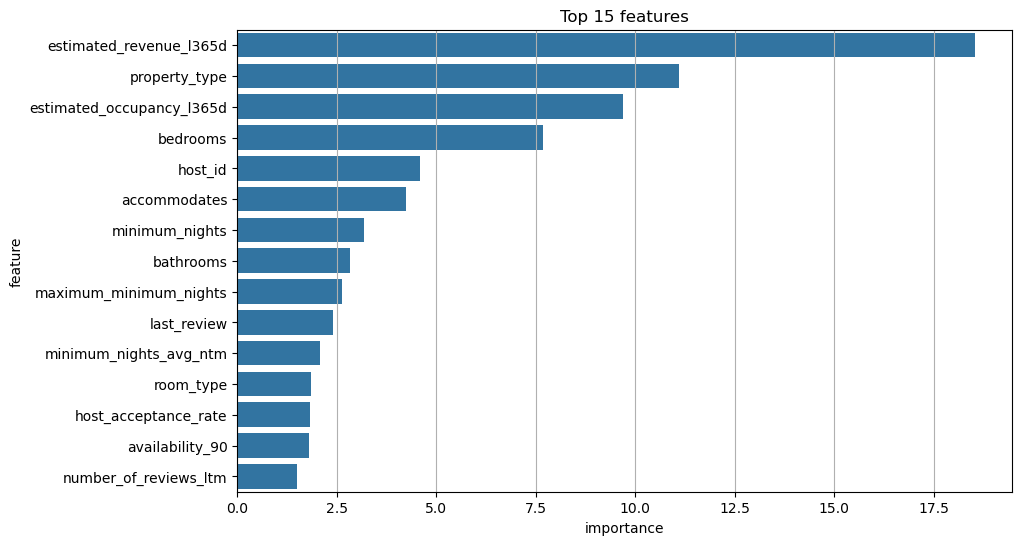

In [41]:
# Step 6: Feature importance plot
feature_importances = pd.DataFrame({
                        'feature' : X.columns,
                        'importance' : model.get_feature_importance()
                                 })

feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.grid()
sns.barplot(data=feature_importances[0:15], y='feature', x='importance', orient='h').set_title("Top 15 features")

feature_importances[0:5]

# 👽 Same model without the estimated_revenue_l365d feature.
This feature is not in the data dictionary and seems like very predictive. Our guess is if its not a direct function of price then it is usable otherwise not.

Will have to do gridsearch again without this feature and find new best model.

In [43]:
df['estimated_revenue_l365d'].corr(df['log_price'], method='pearson')

np.float64(0.3763690403703258)

In [44]:
%%time
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# Step 1: Prepare features and target (same as before)
X = df.drop(columns=['log_price','estimated_revenue_l365d'])
y = df[['log_price']]

# Categorical features and date processing (same as before)
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
X = X.astype({i:str for i in categorical_features})
date_cols = ['host_since', 'first_review', 'last_review']
for col in date_cols:
    X[col] = pd.to_datetime(X[col]).astype('int64')

# Step 2: Split into train and test ONCE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Proper grid search with train/val split from ONLY training data
param_grid = {
    'iterations': [1000, 2000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [2, 4, 6, 7]
}

# Create validation set from ONLY training data and keep test_data untouched
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60/20/20 split on everall data.

grid_search = GridSearchCV(
    estimator=CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='R2',
        random_seed=42,
        verbose=0,
    ),
    param_grid=param_grid,
    cv=[(list(range(len(X_train_train))), list(range(len(X_train_train),len(X_train)))) ],
    scoring='r2',
    n_jobs=4,
    verbose=1,
)

# Train ONLY on training data (X_train)
grid_search.fit(
    X_train, y_train,
    eval_set=(X_val, y_val), # Validation from train split
    cat_features=categorical_features,
    early_stopping_rounds=50,
)

# Get best model and evaluation on validation set and held and my held-out test set
best_model = grid_search.best_estimator_
print(f"->Best GridSearch params: {grid_search.best_params_}")
print(f"->Best params: {best_model.get_params()}")
print(f"->Best Score: {grid_search.best_score_:.4f}")

print("\n->Validation Set Performance:")
evaluate_regression_model(best_model, X_train_train, y_train_train, X_val, y_val)
print("\n->Test Set Performance:")
evaluate_regression_model(best_model, X_train, y_train, X_test, y_test)

Fitting 1 folds for each of 24 candidates, totalling 24 fits
->Best GridSearch params: {'depth': 7, 'iterations': 2000, 'learning_rate': 0.01}
->Best params: {'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 0, 'eval_metric': 'R2', 'depth': 7, 'iterations': 2000, 'learning_rate': 0.01}
->Best Score: 0.7283

->Validation Set Performance:

->Evaluation Metrics:
+----------+---------+--------+
| Metric   |   Train |   Test |
+==========+=========+========+
| RMSE     |   0.248 |  0.257 |
+----------+---------+--------+
| R²       |   0.834 |  0.816 |
+----------+---------+--------+

->Test Set Performance:

->Evaluation Metrics:
+----------+---------+--------+
| Metric   |   Train |   Test |
+==========+=========+========+
| RMSE     |   0.250 |  0.322 |
+----------+---------+--------+
| R²       |   0.830 |  0.730 |
+----------+---------+--------+
CPU times: user 1min 29s, sys: 8.37 s, total: 1min 38s
Wall time: 1min 50s


,feature,importance
17,property_type,11.400951
21,bedrooms,9.336147
19,accommodates,7.472600
0,host_id,5.784140
20,bathrooms,4.626869


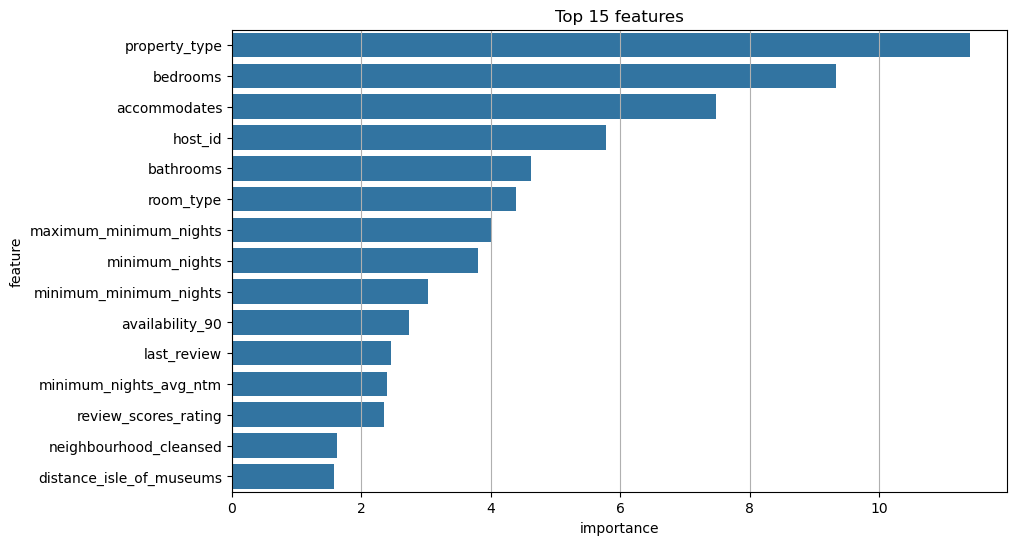

In [45]:
# Step 6: Feature importance plot
feature_importances = pd.DataFrame({
                        'feature' : X.columns,
                        'importance' : best_model.get_feature_importance()
                                 })

feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.grid()
sns.barplot(data=feature_importances[0:15], y='feature', x='importance', orient='h').set_title("Top 15 features")

feature_importances[0:5]

0:	learn: 0.0845972	test: 0.0871864	best: 0.0871864 (0)	total: 5.46ms	remaining: 10.9s
50:	learn: 0.6640819	test: 0.6708525	best: 0.6708525 (50)	total: 247ms	remaining: 9.45s
100:	learn: 0.7153990	test: 0.7031487	best: 0.7031487 (100)	total: 489ms	remaining: 9.2s
150:	learn: 0.7471379	test: 0.7189628	best: 0.7189628 (150)	total: 732ms	remaining: 8.96s
200:	learn: 0.7701215	test: 0.7252191	best: 0.7253998 (199)	total: 985ms	remaining: 8.81s
250:	learn: 0.7861096	test: 0.7284417	best: 0.7287059 (248)	total: 1.25s	remaining: 8.68s
300:	learn: 0.8018622	test: 0.7330429	best: 0.7331689 (299)	total: 1.5s	remaining: 8.47s
350:	learn: 0.8136809	test: 0.7351518	best: 0.7351939 (348)	total: 1.75s	remaining: 8.24s
400:	learn: 0.8240421	test: 0.7360232	best: 0.7360399 (386)	total: 2s	remaining: 7.96s
450:	learn: 0.8351606	test: 0.7370211	best: 0.7371743 (446)	total: 2.24s	remaining: 7.68s
500:	learn: 0.8444775	test: 0.7380511	best: 0.7385724 (495)	total: 2.48s	remaining: 7.41s
Stopped by overfitti

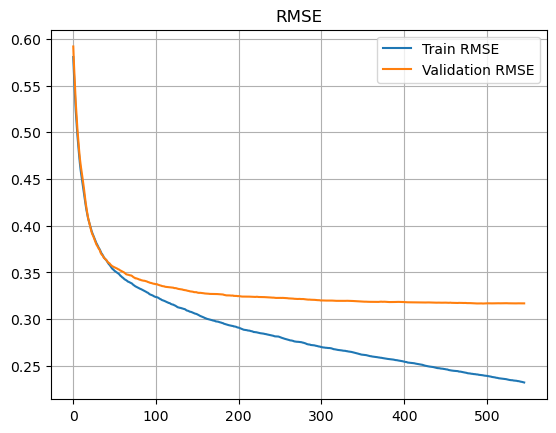

CPU times: user 17.8 s, sys: 1.9 s, total: 19.7 s
Wall time: 2.88 s


(None, <matplotlib.legend.Legend at 0x14e338800>, Text(0.5, 1.0, 'RMSE'), None)

In [47]:
%%time
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Step 1: Prepare the features (X) and target (y)
X = df.drop(columns=['log_price','estimated_revenue_l365d'])
y = df[['log_price']]

# Categorical features
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Make sure these features are of object type
X = X.astype({i:str for i in categorical_features})

# Date Features:
date_cols = ['host_since', 'first_review', 'last_review']  # Replace with your date columns
for col in date_cols:
    X[col] = pd.to_datetime(X[col]).astype('int64')  # Convert to Unix timestamp

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize CatBoostRegressor with parameters and specify categorical features
model = CatBoostRegressor(
    **best_model_params
)

# Step 4: Train the model on the training data
# model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features, early_stopping_rounds=50)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=categorical_features,
    early_stopping_rounds=50,
    verbose=50,
    # plot=True  # Optional: Shows live R²/RMSE plot
)

# Step 5: Evaluate the model
evaluate_regression_model(model, X_train, y_train, X_test, y_test)

# Extract training/validation loss history
train_loss = model.evals_result_['learn']['RMSE']  # Training loss
val_loss = model.evals_result_['validation']['RMSE']  # Validation loss

# Plot the loss curves
plt.plot(train_loss, label='Train RMSE')
plt.plot(val_loss, label='Validation RMSE')
plt.grid(True), plt.legend(), plt.title("RMSE"), plt.show()